In [76]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils import get_path, dist_kwargs_to_str
from pd_utils import get_persistent_feature_id
from io_utils import load_multiple_res
from dist_utils import get_dist
from toydata_utils import get_toy_data
from vis_utils.plot import plot_scatter
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [77]:
style_file = "mpl_style.txt"
plt.style.use(style_file)
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

## Visualization of distances and  PDs with varying ambient dimension 


In [16]:
sigma = 0.25
seed = 2
n = 1000
embd_dim = 50
x = get_toy_data(dataset="toy_circle", d=embd_dim, n=n, sigma=sigma, seed=seed, gaussian={"sigma": sigma})
x_pca = PCA(2).fit_transform(x)

d_eucl = get_dist(x, distance="euclidean")
d_eff = get_dist(x, distance="eff_res", k=100, weighted=True, disconnect=True, corrected=True)
d_diff = get_dist(x, distance="diffusion", k=100, t=8, kernel="sknn", include_self=False)

In [17]:
pt_id = 2
sigma = 0.25
seed = 0
n = 1000
embd_dim = 50



In [18]:

x = get_toy_data(dataset="toy_circle", d=embd_dim, n=n, sigma=sigma, seed=seed, gaussian={"sigma": sigma})

d_eucl = get_dist(x, distance="euclidean")
d_eff = get_dist(x, distance="eff_res", k=100, weighted=True, disconnect=True, corrected=True)
d_diff = get_dist(x, distance="diffusion", k=100, t=8, kernel="sknn", include_self=False)

mds = MDS(2, eps=1e-6, max_iter=6000, dissimilarity="precomputed")

mds_eucl = mds.fit_transform(d_eucl)
mds_eff = mds.fit_transform(d_eff)
mds_diff = mds.fit_transform(d_diff)


/gpfs01/berens/user/sdamrich/miniconda3/envs/ph/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/gpfs01/berens/user/sdamrich/miniconda3/envs/ph/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/gpfs01/berens/user/sdamrich/miniconda3/envs/ph/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [19]:
# set hyperparameters
embd_dims = [2, 10, 20, 30, 40, 50]
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]
n = 1000

dataset = "toy_circle"

distances = {"euclidean": [{}],
             }

dist_2_full_dist = {dist: dist + dist_kwargs_to_str(distances[dist][0]) for dist in distances}

In [20]:
# load PH results
all_res = load_multiple_res(datasets=dataset, 
                            distances=distances,
                            root_path=root_path,
                            n=n,
                            seeds=seeds,
                            sigmas=sigmas,
                            embd_dims=embd_dims, 
                            n_threads=10)

Done with toy_circle 2 euclidean
Done with toy_circle 10 euclidean
Done with toy_circle 20 euclidean
Done with toy_circle 30 euclidean
Done with toy_circle 40 euclidean
Done with toy_circle 50 euclidean


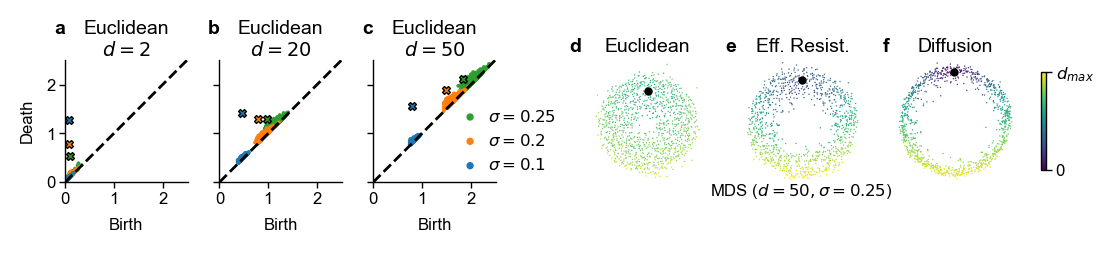

In [78]:
# plot figure

selected_sigmas = [0.1, 0.2, 0.25]
selected_dims = [2, 20, 50]
seed = 0

fig, ax = plt.subplots(ncols = len(selected_sigmas) + 3, width_ratios=(1,1,1,1., 1., 1.), figsize=(5.5, 1.15))

cmap = plt.get_cmap("tab10")
size = 7
lims = []

letters = "abcdef"
# plot persistence diagrams for different dimensions and noise levels
for i, d in enumerate(selected_dims):
    for j, sigma in sorted(enumerate(selected_sigmas), reverse=True):
        res = all_res[d]["euclidean"]["euclidean"][sigma][seed]

        if d == 50 and sigma == 0.25:
            ind = get_persistent_feature_id(res, dim=1, m=2) # correct loop is not most persistent
        else:
            ind = get_persistent_feature_id(res, dim=1)

        mask = np.ones(len(res["dgms"][1]), dtype=bool)
        mask[ind] = False
        if i == 2:
            ax[i].scatter(*res["dgms"][1][mask].T,
                       color=cmap(j),
                       s=size,
                       alpha=1,
                       label=f"$\sigma = {sigma}$",
                       edgecolor="none"
                       )
        else:
            ax[i].scatter(*res["dgms"][1][mask].T,
                       color=cmap(j),
                       s=size,
                       alpha=1,
                        edgecolor="none"
                       )
        # mark feature of correct loop
        ax[i].scatter(*res["dgms"][1][ind].T,
                       color=cmap(j),
                       s=size+1,
                      marker="X",
                      edgecolor="k",
                      linewidth=0.5,
                       alpha=1,
                       )
    # prettify the plots
    xlim = ax[i].get_xlim()[1]
    ylim = ax[i].get_ylim()[1]
    lim = max(xlim, ylim)
    lims.append(lim)
    
    ax[i].set_xlabel("Birth")
    if i == 0:
        ax[i].set_ylabel("Death")
        ax[i].set_xticks([0, 1, 2])
    else:
        ax[i].set_xticks([0, 1, 2])
        ax[i].set_yticklabels([])
    ax[i].set_aspect("equal", "box")
    
    title = ax[i].set_title(f"Euclidean\n$d = {d}$", va="top")
    ax[i].set_title(
        letters[i]+"\n",
        loc="left",
        ha="right",
        va="top",
        fontweight="bold",
    )

ax[2].legend(loc=(0.6, 0.02),
             frameon=False, 
             ncols=1,
             handletextpad=0.1,
             markerscale=2.0
        )

    
lim = np.max(lims)
for i in range(len(selected_sigmas)):
    
    ax[i].plot([0, lim], [0, lim], "--", c="k", linewidth=1)

    ax[i].set_xlim(0, lim)
    ax[i].set_ylim(0, lim)
    


# plot MDS embeddings

pt_id=3  # id for reference point

# get angles to rotate reference point to top
theta_eucl = np.arccos((mds_eucl[pt_id] / np.linalg.norm(mds_eucl[pt_id])).dot(np.array([0, 1])))
rot_eucl = np.array([[np.cos(theta_eucl), -np.sin(theta_eucl)], 
                     [np.sin(theta_eucl), np.cos(theta_eucl)]])


theta_eff = - np.arccos((mds_eff[pt_id] / np.linalg.norm(mds_eff[pt_id])).dot(np.array([0, 1])))
rot_eff = np.array([[np.cos(theta_eff), -np.sin(theta_eff)], 
                     [np.sin(theta_eff), np.cos(theta_eff)]])

theta_diff = np.arccos((mds_diff[pt_id] / np.linalg.norm(mds_diff[pt_id])).dot(np.array([0, 1])))
rot_diff = np.array([[np.cos(theta_diff), -np.sin(theta_diff)], 
                     [np.sin(theta_diff), np.cos(theta_diff)]])


# plot MDS scatter plots
plot_scatter(ax=ax[3], x=mds_eucl@rot_eucl, y=d_eucl[pt_id], alpha=1, s=1, cmap="viridis", scalebar=False)
plot_scatter(ax=ax[4], x=mds_eff@rot_eff, y=d_eff[pt_id], alpha=1, s=1, cmap="viridis", scalebar=False)
scatter = plot_scatter(ax=ax[5], x=mds_diff@rot_diff, y=d_diff[pt_id], alpha=1, s=1, cmap="viridis", scalebar=False)

# plot reference point
ax[0+3].scatter(*(mds_eucl[pt_id]@rot_eucl).T, c="k")
ax[1+3].scatter(*(mds_eff[pt_id]@rot_eff).T, c="k")
ax[2+3].scatter(*(mds_diff[pt_id]@rot_diff).T, c="k")

# prettify MDS embeddings
ax[0+3].set_title("Euclidean", )
ax[1+3].set_title("Eff. Resist.",)
ax[2+3].set_title("Diffusion",)


txt = ax[1+3].text(x=-0.2, y=-0., s="MDS ($d=50, \sigma=0.25$)", transform=ax[1+3].transAxes, va="top")
txt.set_in_layout(False)

ax[0+3].set_aspect("equal", "datalim")
ax[1+3].set_aspect("equal", "datalim")
ax[2+3].set_aspect("equal", "datalim")

for i in range(3):
    i+=3
    ax[i].set_title(
        letters[i],
        ha="right",
        loc="left",
        fontweight="bold",
    )

cbar= fig.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02 )
cbar.ax.set_yticks([0, d_diff[pt_id].max()]) 
cbar.ax.set_yticklabels(["0", "$d_{max}$"]) 

fig.savefig(os.path.join(fig_path, "fig_pd_by_dim_mds.pdf"))

In [ ]:
# note that title alignment is different in the pdf than displayed here.